In [ ]:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

class NeuralNetwork():
  


    def __init__(self, loss='crossentropy', classifier='categorical', metric='accuracy', learning_rate=.04):
        ALLOWED_LOSSES = ['crossentropy']
        ALLOWED_CLASSIFIERS = ['binary', 'categorical']
        ALLOWED_METRICS = ['accuracy','percision','recall','f1 score']

        self.W = [np.NaN]
        self.b = [np.NaN]
        self.Z = [np.NaN]
        self.A = [np.NaN]

        self.layer_activations = [None]
        self.layer_units = [0]
        self.layer_initializers = [None]

        self.loss_function = loss
        self.classifier = classifier
        self.metric = metric
        self.loss_history = [np.NaN]
        self.metric_history = [np.NaN]
        self.loss = 0.
        self.learning_rate = learning_rate

    def activation_func(self, z, activation=None, return_derivative=False):

        if activation == 'sigmoid':
            s = 1/(1 + np.exp(-z))
            if return_derivative:
                return s*(1 - s)

        elif activation == 'tanh':
            s = np.tanh(z)
            if return_derivative:
                return 1 - s**2

        elif activation == 'reLU':
            s = np.maximum(z, 0)
            if return_derivative:
                return (s > 0)*s

        elif activation == 'leakyrelu':
            s = np.where(z > 0, z, z * 0.01)
            if return_derivative:
              s = np.ones_like(z)
              s[z < 0] = alpha
              return s

        elif activation == 'softmax':
            max_z = np.max(z, axis=0, keepdims=True)
            s = np.exp(z - max_z)
            norm = np.sum(s, axis=0, keepdims=True)
            s = s/norm
            if return_derivative:
                return s*(1-s)

        return s

    def forward_propagate(self):
        num_layers = len(self.layer_units) - 1
        for l in range(1, num_layers+1):
            self.Z[l] = np.dot(self.W[l], self.A[l-1]) + self.b[l]
            self.A[l] = self.activation_func(self.Z[l], activation=self.layer_activations[l])

    def calculate_output_dZ(self, actual):

        if self.classifier=='categorical':
            if self.loss_function=='crossentropy':
                return -actual*(1 - self.A[-1])
        elif self.classifier=='binary':
            if self.loss_function=='crossentropy':
                return -actual + self.A[-1]

    def backward_propagate(self, actual):

        m = actual.shape[-1]
        num_layers = len(self.layer_units) - 1

        # Iterate from layer L-1 to layer 1
        for l in range(num_layers, 0, -1):
            if l == num_layers:
                dZ = self.calculate_output_dZ(actual)
            else:
                g = self.activation_func(self.Z[l], activation=self.layer_activations[l], return_derivative=True)
                dZ = g*np.dot(np.transpose(self.W[l+1]), dZ) 

            dW = (1/m)*np.dot(dZ, np.transpose(self.A[l-1]))
            dB = (1/m)*np.sum(dZ, axis=1, keepdims=True)

            # Update parameters
            self.W[l] = self.W[l] - self.learning_rate*dW
            self.b[l] = self.b[l] - self.learning_rate*dB



    def calculate_loss(self, actual):

        m = actual.shape[-1]
        predicted = self.A[-1]


        if self.loss_function == 'crossentropy' and self.classifier == 'binary':
            loss_vector = -actual*np.log(predicted) - (1 - actual)*np.log(1-predicted)
        elif self.loss_function == 'crossentropy' and self.classifier == 'categorical':
            loss_vector = np.sum(-actual*np.log(predicted), axis=0, keepdims=True)

        self.loss = (1/m)*np.sum(loss_vector)
        self.loss_history.append(self.loss)


    def initialize_params(self, X_input):

        self.layer_units[0] = X_input.shape[0]
        m = X_input.shape[-1]

        num_layers = len(self.layer_units) - 1
        for l in range(1, num_layers+1):
            n_l = self.layer_units[l]
            n_prev = self.layer_units[l-1]

            if self.layer_initializers[l] == 'zeros':
                self.W.append(np.zeros(shape=(n_l, n_prev), dtype=np.float32))
                self.b.append(np.zeros(shape=(n_l, 1), dtype=np.float32))
            elif self.layer_initializers[l] == 'random':
                self.W.append(np.random.rand(n_l, n_prev).astype(np.float32))
                self.b.append(np.random.rand(n_l, 1).astype(np.float32))

            elif self.layer_initializers[l] == 'xavier':
                stddev = np.sqrt(1/n_prev)
                self.W.append(stddev*np.random.randn(n_l, n_prev).astype(np.float32))
                self.b.append(stddev*np.random.randn(n_l, 1).astype(np.float32))
            else:
                return False
            self.Z.append(np.zeros(shape=(n_l, m), dtype=np.float32))
            self.A.append(np.zeros(shape=(n_l, m), dtype=np.float32))


    def add_layer(self, units, activation='tanh', initializer='xavier'):

        self.layer_units.append(units)
        self.layer_activations.append(activation)
        self.layer_initializers.append(initializer)



    def train(self, x_train, y_train, iterations=1):

        if self.classifier == 'categorical':
            if y_train.ndim == 1:
                one_hot_array = np.zeros(shape=(y_train.max()+1, y_train.size))
                one_hot_array[y_train, np.arange(y_train.size)] = 1
                y_train = one_hot_array
        if self.classifier == 'binary':
            if y_train.ndim == 1:
                y_train = np.expand_dims(y_train, axis=0)


        self.A[0] = x_train
        self.initialize_params(x_train)

        print('Training neural network.')
        for i in range(iterations):

            self.forward_propagate()
            self.calculate_loss(y_train)
            self.backward_propagate(y_train)

            print_step_size = int(iterations/100) if iterations > 100 else 1
            if i % print_step_size == 0:
                print('At iteration {}, J = {}'.format(i, self.loss))

    def test(self, x_test, y_test):

        if y_test.ndim == 1:
            y_test = np.expand_dims(y_test, axis=0)

        if self.classifier == 'categorical':
            if y_test.ndim == 1:
                one_hot_array = np.zeros(shape=(y_test.max()+1, y_test.size))
                one_hot_array[y_test, np.arange(y_test.size)] = 1
                y_test = one_hot_array
        if self.classifier == 'binary':
            if y_test.ndim == 1:
                y_test = np.expand_dims(y_test, axis=0)

        self.A[0] = x_test
        self.forward_propagate()
        return self.A[-1]


    def evaluation_matrix(self, prediction, actual):

        
        prediction_onehot = np.zeros_like(prediction)
        prediction_onehot[prediction.argmax(0), np.arange(prediction.shape[1])] = 1

        predictedClass= prediction_onehot.T 
        one_dim_predicted_class=[]
        for i in range(len(predictedClass)):
            one_dim_predicted_class.append(np.argmax(predictedClass[i]))
        
        actual_list=actual.tolist()
        sum=0
        for i in range(len(actual_list)):
          if actual_list[i]==one_dim_predicted_class[i]:
              sum+=1
        print("accuracy = ", (sum/ len(actual_list))*100)
        currentDataClass=actual_list
        classes = set(currentDataClass)
        number_of_classes = prediction.shape[0]
        y_actu = pd.Series(currentDataClass)
        y_pred = pd.Series(one_dim_predicted_class)
        conf_matrix = pd.crosstab(y_actu, y_pred)
        cm = conf_matrix.values

        true_pos = np.diag(cm)
        false_pos = np.sum(cm, axis=0) - true_pos
        false_neg = np.sum(cm, axis=1) - true_pos
        print(true_pos.sum(),false_pos.sum(), false_neg.sum())

        precision = true_pos.sum()/ (true_pos.sum() + false_pos.sum()+0.00001)
        recall = true_pos.sum() / (true_pos.sum() + false_neg.sum())
        f1_score= 2*( (precision*recall) / (precision+recall) )
        print("precision = ",precision*100)
        print("f1_score = ",f1_score*100)
        print("recall = ",recall*100)


    def visualize(self):
      import matplotlib.pyplot as plt
      plt.plot(self.loss_history)
      plt.title('Loss Vs iterations')
      plt.xlabel('iterations')
      plt.ylabel('L')
      plt.show()



In [ ]:
class Data():
      def shuffle_split_data(self,X,y,train_size=0.7):
        arr_rand = np.random.rand(X.shape[0])
        split = arr_rand < np.percentile(arr_rand, train_size*100)
        X_train =  np.array(X[split]).T
        y_train = np.array(y[split]).ravel()
        X_test = np.array( X[~split]).T
        y_test = np.array(y[~split]).ravel()
        return X_train, y_train, X_test, y_test

      def load_data(self,path,label):
        data=pd.read_csv(path)
        Y = data[[label]]
        data.drop([label], inplace=True, axis=1)
        X=data
        return self.shuffle_split_data(X,Y)

In [ ]:
class utils():
  def load_model(self,filename):
    import pickle 
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

  def save_model(self,nn,filename):
    import pickle 
    pickle.dump(nn, open(filename, 'wb'))


Training neural network.
At iteration 0, J = 2.4808302946838623
At iteration 1, J = 2.4108455796533166
At iteration 2, J = 2.3719569035803465
At iteration 3, J = 2.3317656886168687
At iteration 4, J = 2.295038871792033
At iteration 5, J = 2.259310426279142
At iteration 6, J = 2.2209015202438467
At iteration 7, J = 2.1916729211236454
At iteration 8, J = 2.1667405521642142
At iteration 9, J = 2.1458170624828266
At iteration 10, J = 2.123119359040292
At iteration 11, J = 2.1055316590308717
At iteration 12, J = 2.08210624180616
At iteration 13, J = 2.0673951310204313
At iteration 14, J = 2.051421320345106
At iteration 15, J = 2.036378836486892
At iteration 16, J = 2.022381606670033
At iteration 17, J = 2.0105593962531136
At iteration 18, J = 1.9950982854361778
At iteration 19, J = 1.988422820040294
At iteration 20, J = 1.9745299827336502
At iteration 21, J = 1.9695098392705095
At iteration 22, J = 1.9550195659151994
At iteration 23, J = 1.9438356659713256
At iteration 24, J = 1.93698342910

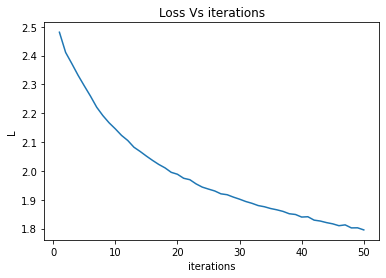

accuracy =  39.58730158730159
4988 7612 7612
precision =  39.587301555883094
f1_score =  39.58730157159235
recall =  39.58730158730159


In [ ]:
if __name__ == '__main__':
    import numpy as np
    import pandas as pd
    # Initialize the NN and build the layers
    nn = NeuralNetwork(loss='crossentropy', classifier='categorical', learning_rate=.02, metric='accuracy')
    nn.add_layer(units=20, activation='tanh', initializer='xavier')
    nn.add_layer(units=40, activation='tanh', initializer='xavier')
    nn.add_layer(units=10, activation='softmax', initializer='xavier')
    data_loader=Data()
    path='/content/drive/MyDrive/datasets/train.csv'
    label='label'
    x_train, y_train, x_test, y_test=data_loader.load_data(path,label)
    nn.train(x_train=x_train, y_train=y_train, iterations=50)
    nn.visualize()
    # Test NN on our test set
    prediction = nn.test(x_test=x_test, y_test=y_test)
    nn.evaluation_matrix(prediction , y_test)
    util=utils()
    filename = 'final_model2.sav'
    util.save_model(nn,filename)

In [ ]:
    
    x=util.load_model(filename)
    pred=x.test(x_test,y_test)
    x.evaluation_matrix(pred,y_test)

accuracy =  39.58730158730159
4988 7612 7612
precision =  39.587301555883094
f1_score =  39.58730157159235
recall =  39.58730158730159
